# Hopskotch GCN Circular Message Import Sample: IceCube 210717A and AllWISE AGN Catalog Crossmatch

Authors: Amanda Beck, Zsuzsa Marka

## Index:

1. [AllWISE AGN Catalog Data](#AllWISE-AGN-Catalog-Data:)
2. [Testing Connection to Hop](#Testing-Connection-to-Hop:)
3. [Importing All Available GCN Circular Messages](#Importing-All-Available-GCN-Circular-Messages:)
4. [Reading and Querying Messages](#Reading-and-Querying-Messages:)
5. [Defining IceCube-210730A Circular Contour](#Defining-IceCube-210730A-Circular-Contour:)
6. [Crossmatch](#Crossmatch:)
7. [Plotting](#Plotting:)
8. [Resources](#Resources:)

In [1]:
# general imports:
from astropy.table import Column, Table, join
from astropy.coordinates import SkyCoord
from matplotlib import pyplot as plt
import astropy.coordinates as coord
from astropy.io import fits, ascii
import astropy.units as u
import ligo.skymap.moc
import healpy as hp
import numpy as np

# hop-specific imports:
from hop import Stream
from hop import stream
from hop.io import StartPosition

# imports from src code:
import sys
sys.path.append('../src')
from functions import plot_mollview

# defining plot inclusion in notebook:
%matplotlib inline

## AllWISE AGN Catalog Data:

For the purpose of this demonstration, we are using the AllWISE AGN catalog. The link to the catalog can be found in [Resources](#Resources:).

In [2]:
# opening BBH LIGO data:
cat = '../data/allwise.fits' 
allwise = Table.read(cat, format='fits')

# adjusting RA and DEC column names to fit with our convention:
allwise['RA'].name = 'RAJ2000'
allwise['DEC'].name = 'DEJ2000'

allwise[:5]

NAME,RAJ2000,DEJ2000,LII,BII,W1W2_COLOR,W2W3_COLOR,W1_MAG,GMAG,REDSHIFT,REDSHIFT_FLAG,LQAC2_NAME,DR12Q_NAME,MILLIQUAS_NAME
,DEGREE,DEGREE,DEGREE,DEGREE,MAG,MAG,MAG,MAG,,,,,
bytes25,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes13,bytes17,bytes24,bytes26
WISEA J184245.06-894911.0,280.68778,-89.81973,303.13432,-27.12127,0.95,3.48,15.15,0.00,0.00000,,,,
WISEA J043431.62-894617.9,68.63175,-89.77165,302.71954,-27.25653,1.32,3.07,15.12,0.00,0.00000,,,,
WISEA J220915.15-894514.2,332.31317,-89.75395,303.11194,-27.31510,0.95,3.57,16.08,0.00,0.00000,,,,
WISEA J094017.96-894442.8,145.07485,-89.74523,302.72023,-26.95691,0.96,3.16,14.27,0.00,0.00000,,,,
WISEA J233728.16-894436.2,354.36737,-89.74341,303.02356,-27.37156,1.04,3.00,15.21,0.00,0.00000,,,,


## Testing Connection to Hop:

In [3]:
# testing connectivity:
with Stream(persist=True).open("kafka://kafka.scimma.org/sys.heartbeat", "r") as src:
    for i, message in zip(range(5), src):
        print(i, message)
# time in unix time.
# count since system is up that day.

0 {'timestamp': 1631836432919955, 'count': 83450, 'beat': 'LISTEN'}
1 {'timestamp': 1631836433921327, 'count': 83451, 'beat': 'listen to my heart beat'}
2 {'timestamp': 1631836434922726, 'count': 83452, 'beat': 'listen'}
3 {'timestamp': 1631836435924105, 'count': 83453, 'beat': 'Listen'}
4 {'timestamp': 1631836436925624, 'count': 83454, 'beat': 'LISTEN'}


## Importing All Available GCN Circular Messages:

In [4]:
# making a Stream object:
stream = Stream(start_at=StartPosition.EARLIEST) # specifying where to start (EARLIEST gets all of the available)

# creating a message list:
messages = []

# printing messeges for GCN circulars:
with stream.open("kafka://kafka.scimma.org/gcn.circular", "r") as s:
    for message in s:
        messages.append(message)

print(messages[:2])

[GCNCircular(header={'title': 'GCN CIRCULAR', 'number': '30656', 'subject': 'Swift Trigger 1069242 is Cyg X-1', 'date': '21/08/18 16:55:58 GMT', 'from': 'Kim Page at U.of Leicester  <klp5@leicester.ac.uk>'}, body='A. P. Beardmore (U Leicester), J.D. Gropp (PSU),\nF. E. Marshall (NASA/GSFC), K. L. Page (U Leicester),\nM. H. Siegel (PSU) and A. Tohuvavohu (U Toronto) report on behalf of\nthe Neil Gehrels Swift Observatory Team:\n\nAt 16:17:00 UT, the Swift Burst Alert Telescope (BAT) triggered and\nlocated Cyg X-1 (trigger\x1069242).  Swift slewed immediately to the source.\nThe BAT on-board calculated location is\nRA, Dec 299.819, +35.277 which is\n   RA(J2000) = 19h 59m 16s\n   Dec(J2000) = +35d 16\' 37"\nwith an uncertainty of 3 arcmin (radius, 90% containment, including\nsystematic uncertainty). This onboard position is 12 arcminutes from the\nknown position of Cyg X-1, likely due to higher than typical attitude\nuncertainty from the star trackers.\nAs is typical for an image trigger

## Reading and Querying Messages:

In [5]:
messages[0].serialize()['content']['header']

{'title': 'GCN CIRCULAR',
 'number': '30656',
 'subject': 'Swift Trigger 1069242 is Cyg X-1',
 'date': '21/08/18 16:55:58 GMT',
 'from': 'Kim Page at U.of Leicester  <klp5@leicester.ac.uk>'}

In [6]:
# creating a list of readable messages:
readable_messages = []

# serializing messages into readable dictionaries:
for m in messages:
    readable_messages.append(m.serialize())

In [7]:
# make list of messages matching what we want (IceCube events):
IceCube_messages = []
other_messages = []

for i in range(len(readable_messages)):
    if ('IceCube observation of a high-energy neutrino candidate' in 
        readable_messages[i]['content']['header']['subject']):
        IceCube_messages.append(readable_messages[i])
    else:
        other_messages.append(readable_messages[i])

In [8]:
IceCube_messages

[]

## Defining IceCube-210717A Circular Contour:

In [9]:
# creating empty skymap:
n_side_empty = 128
n_pix_empty = hp.nside2npix(n_side_empty)
hpix_empty = np.zeros(n_pix_empty)

# defining central coordinates and radius:
cent_ra = 46.49 # central RA [deg] rotated 180 for the plotting convention.
cent_dec = -1.34 # central DEC [deg]
radius = 2.7525*u.deg # averaged errors on ra and dec for simplicity of plotting a circle. [deg]

# defining offset angle array:
theta = np.linspace(0, 360, 200)*u.deg # [deg]
center = SkyCoord(cent_ra*u.deg, 
                  cent_dec*u.deg, 
                  frame='icrs')
circle = center.directional_offset_by(theta, 
                                      radius)

# defining RA and DEC of circle points:
circ_ra = circle.ra.degree
circ_dec = circle.dec.degree

## Crossmatch:

In [10]:
# overlapping AllWISE with this circle:
# matches will have offset angle less than or equal to 2.7525deg
allwise_coords = SkyCoord(np.array(allwise['RAJ2000'])*u.deg, 
                          np.array(allwise['DEJ2000'])*u.deg, 
                          frame='icrs')
center_coords = SkyCoord(np.full(len(allwise_coords), cent_ra)*u.deg, 
                         np.full(len(allwise_coords), cent_dec)*u.deg, 
                         frame='icrs')

distances = center_coords.separation(allwise_coords).value
indexes_matches = np.where(distances <= 2.7525)
        
icecube_matches_ra = allwise['RAJ2000'][indexes_matches[0]]
icecube_matches_dec = allwise['DEJ2000'][indexes_matches[0]]
# this can also be done with AXS, once it is public.

# if you want to save the matches with all info available in allwise, do this:
matches = allwise[indexes_matches[0]]

# number of matches:
number_matches = len(indexes_matches[0])
print('Number of AllWISE sources in IceCube-210717A area: ' + str(number_matches))

Number of AllWISE sources in IceCube-210717A area: 849


## Plotting:

0.0 180.0 -180.0 180.0
The interval between parallels is 15 deg -0.00'.
The interval between meridians is 15 deg -0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 15 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


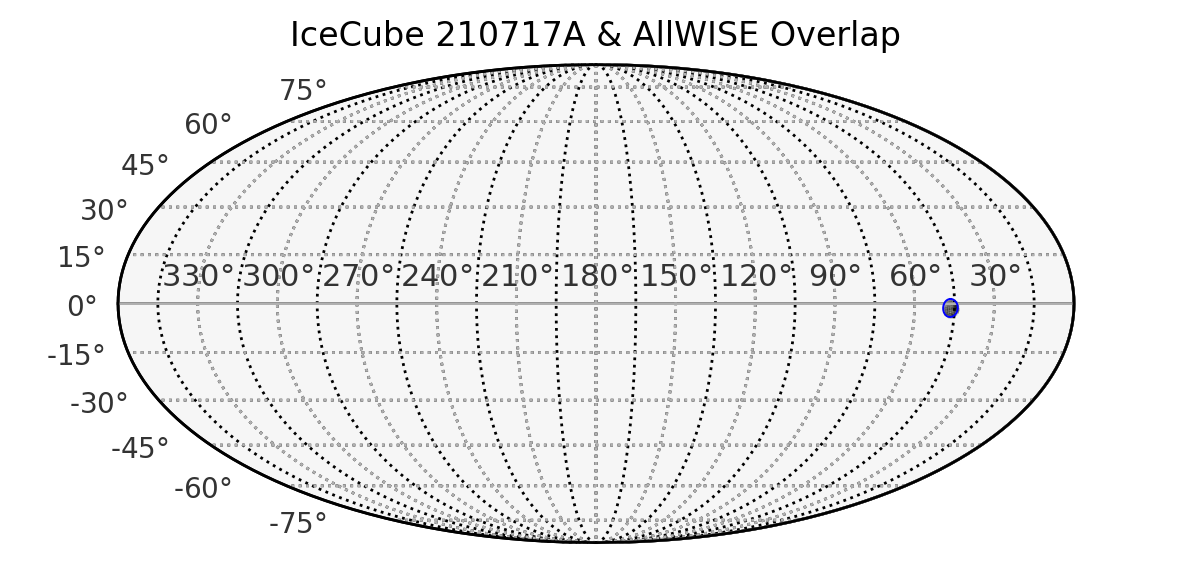

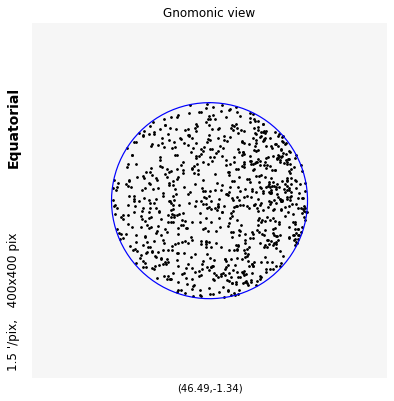

In [11]:
plot_mollview(hpix_empty, 
              nest=True, 
              cmap='PiYG', 
              title='IceCube 210717A & AllWISE Overlap', 
              cbar=False, 
              unit=None)
hp.projplot(circ_ra, 
            circ_dec, 
            lonlat=True, 
            coord='C', 
            c='b', 
            linewidth=0.7)
hp.projscatter(icecube_matches_ra, 
               icecube_matches_dec, 
               lonlat=True, 
               s=0.0001,
               c='k')

plt.savefig('../plots/IceCube_AllWISE_overlap.pdf')

hp.gnomview(hpix_empty, 
            nest=True, 
            cmap='PiYG',
            rot=(cent_ra, cent_dec, 0),
            coord='C',
            xsize=400,
            cbar=False)
hp.projplot(circ_ra, 
            circ_dec, 
            lonlat=True, 
            coord='C', 
            c='b', 
            linewidth=1.2)
hp.projscatter(icecube_matches_ra, 
               icecube_matches_dec, 
               lonlat=True, 
               s=3, 
               c='k')

## Resources:

### Hopskotch:
1. [Hopskotch Documentation](https://hop-client.readthedocs.io/en/latest/user/installation.html)
2. Installing `hop-client`: `pip install hop-client`

### General Resources:
1. [Astropy](https://www.astropy.org)
2. [HEALPy Documentation](https://healpy.readthedocs.io/en/latest/)
2. [GWOSC](https://www.gw-openscience.org/about/)
3. [Anaconda Documentation](https://docs.anaconda.com/anaconda/)
4. [Conda Documentation](https://docs.conda.io/projects/conda/en/latest/index.html)
5. [Conda Forge](https://conda-forge.org/docs/user/introduction.html)
6. [Finding Highest Probability for Multiorder Skymaps](https://emfollow.docs.ligo.org/userguide/tutorial/multiorder_skymaps.html)
8. [Multi-Order Skymaps](https://emfollow.docs.ligo.org/userguide/tutorial/multiorder_skymaps.html)
7. [LIGO moc Documentation](https://lscsoft.docs.ligo.org/ligo.skymap/moc/index.html)
8. [RA and DEC to Degree Converter](https://www.swift.psu.edu/secure/toop/convert.htm)
9. [SCiMMA Project](https://scimma.org/index.html)